In [1]:
from datetime import datetime

from tqdm import tqdm

CUDF = True
print(f"Using {'cuDF' if CUDF else 'Pandas'}")

if CUDF:
    import cupy as xp
else:
    import numpy as xp


COUNT = 10_000_000
PREVALENCE = 0.10
NUM_NODES = 768

INC_MEAN = xp.float32(7.0)
INC_STD = xp.float32(1.0)
INF_MEAN = xp.float32(7.0)
INF_STD = xp.float32(1.0)
R_NAUGHT = 14.0
BETA = R_NAUGHT / INF_MEAN

t0 = datetime.now(tz=None)  # noqa
susceptibility = xp.ones(COUNT, dtype=xp.uint8)
etimer = xp.zeros(COUNT, dtype=xp.uint8)
itimer = xp.zeros(COUNT, dtype=xp.uint8)
rtimer = xp.zeros(COUNT, dtype=xp.uint16)
nodeid = xp.random.randint(0, NUM_NODES, COUNT).astype(xp.uint16)

infectious = (xp.random.random(COUNT) < PREVALENCE).astype(xp.uint8)
itimer[infectious != 0] = xp.round(
    xp.random.normal(INF_MEAN, INF_STD, int(infectious.sum()))
)
susceptibility[infectious != 0] = 0
t1 = datetime.now(tz=None)  # noqa
# print(f"Elapsed time (initialization): {t1 - t0}")

draw = xp.zeros(COUNT, dtype=xp.float32)
force = xp.zeros(COUNT, dtype=xp.float32)
transmit = xp.zeros(COUNT, dtype=bool)

infected = xp.zeros(NUM_NODES, dtype=xp.uint32)
pops = xp.zeros(NUM_NODES, dtype=xp.uint32)
forces = xp.zeros(NUM_NODES, dtype=xp.float32)

TICKS = 730

t0 = datetime.now(tz=None)  # noqa
prevalence = xp.zeros((TICKS + 1, NUM_NODES), dtype=xp.uint32)
xp.add.at(prevalence[0, :], nodeid[itimer > 0], 1)

...

for tick in tqdm(range(TICKS)):

    # every 90 days import some new cases
    if tick % 90 == 0:
        imports = xp.random.randint(0, COUNT, NUM_NODES).astype(xp.uint32)
        itimer[imports] = xp.random.normal(INF_MEAN, INF_STD, NUM_NODES).astype(xp.uint8) + xp.uint8(1)
    
    # update waning immunity for recovered agents
    susceptible = (rtimer == 1)
    rtimer[rtimer > 0] -= 1
    susceptibility[susceptible] = xp.uint8(1)

    # update infectious timer for infected agents
    recovered = (itimer == 1)
    itimer[itimer > 0] -= 1
    count = int(recovered.sum())
    # set a waning timer for recovered agents
    rtimer[recovered] = xp.round(xp.random.normal(270.0, 30.0, count)).astype(xp.uint16)

    # update incubation timer for exposed agents
    symptomatic = (etimer == 1)
    count = int(symptomatic.sum())
    itimer[symptomatic] = xp.round(
        xp.random.normal(INF_MEAN, INF_STD, count)
    ).astype(xp.uint8)
    etimer[etimer > 0] -= 1

    # determine number of infectious agents by node
    xp.add.at(prevalence[tick + 1, :], nodeid[itimer > 0], 1)
    pops[:] = 0
    xp.add.at(pops, nodeid, 1)
    forces = prevalence[tick + 1, :] / pops
    forces *= BETA

    # do transmission
    draw = xp.random.random(COUNT).astype(xp.float32)
    force = forces[nodeid]
    force *= susceptibility
    transmit = draw < force
    count = int(transmit.sum())
    etimer[transmit] = xp.round(
        xp.random.normal(INC_MEAN, INC_STD, count)
    ).astype(xp.uint8)
    susceptibility[transmit] = xp.uint8(0)

    ...

t1 = datetime.now(tz=None)  # noqa
print(f"Elapsed time (simulation): {t1 - t0}")


Using cuDF


100%|██████████| 730/730 [00:09<00:00, 78.39it/s] 

Elapsed time (simulation): 0:00:09.808566


## Using Pandas
```
100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [10:16<00:00,  1.18it/s]
Elapsed time (simulation): 0:10:16.567508
```

## Using cuDF
```
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 730/730 [00:05<00:00, 137.68it/s]
Elapsed time (simulation): 0:00:05.304470
```

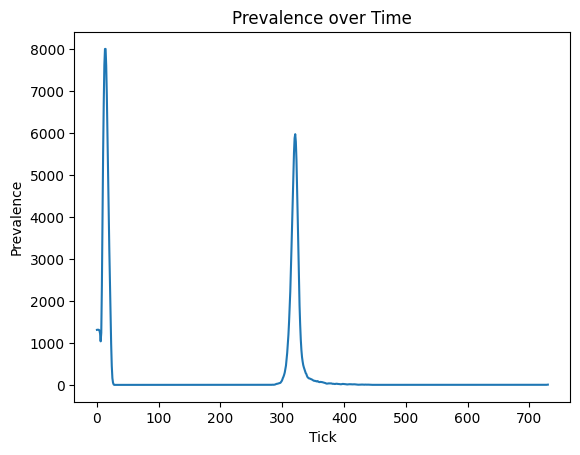

In [2]:
import matplotlib.pyplot as plt

plt.plot((prevalence.get() if CUDF else prevalence)[:, 2])
plt.xlabel('Tick')
plt.ylabel('Prevalence')
plt.title('Prevalence over Time')
plt.show()